# Benchmarks 6-Body Solar System

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-N-body-problem">Definition of the N-body problem</a></li>
    <li><a href="#IRKGL16-integrations">IRKGL16-integrations</a></li>
    <li><a href="#2nd-order-explicit-symplectic-integrations">2nd order explicit symplectic integrations</a></li>
    <li><a href="#Benchmarks-diagrams">Benchmarks diagrams</a></li>
    <ul>
        <li><a href="#Work-precision-diagrams">Work-precision-diagrams</a></li>
        <li><a href="#Error-in-Energy">Error in Energy</a></li>
        <li><a href="#Error-in-Solution">Error in Solution</a></li>
    </ul>
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq

PATH_IRKGL="../../../../IRKGaussLegendre.jl-master/IRKGaussLegendre.jl-master/"
include(string(PATH_IRKGL,"src/IRKGaussLegendre.jl"))
using .IRKGaussLegendre  ## bertsio lokala exekutatzeko  

PATH_Splitting="../../"
include(string(PATH_Splitting,"/src/SplittingMethods.jl"))
using .SplittingMethods  ## bertsio lokala exekutatzeko  

include("../Aux_functions.jl")

lcm_floats_vector (generic function with 1 method)

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [2]:
PATH_ODES=string(PATH_IRKGL,"ODEProblems/")

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))
include(string(PATH_ODES,"Nbody2nd.jl"))
include(string(PATH_ODES,"NbodyDyn.jl"));

include(string(PATH_Splitting,"/ODEProblems/Nbody.jl"))

flowH2Nbody! (generic function with 1 method)

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [3]:
u0, Gm, bodylist = Initial6Body(Float64)

u0_B=BigFloat.(u0)
Gm_B=BigFloat.(Gm)

q0=u0[:,:,1]
v0=u0[:,:,2]

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.522620605966966e-12

In [4]:
# Testing: center of mass of the outer solar system at the origin of coordinates with zero velocity

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:6
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(q0_/Gm0_, v0_/Gm0_)

([1.417048569677335e-18, 9.119357686204585e-20, 1.5082339679877506e-19], [1.0942040830907497e-22, -2.709864045560887e-22, 1.6237832716049163e-22])

In [5]:
t0=0.
tF=1e7   #1e9  # days

tspan= (t0,tF)
tspan_B=(BigFloat(t0),BigFloat(tF))

Jupiter_period = 11.9*365
tF/Jupiter_period

2302.290779325429

In [6]:
year=365.25
tF/year

27378.507871321013

##### <a href="#top">Back to the top</a>

## IRKGL16 integrations

In [7]:
prob = ODEProblem{true,SciMLBase.FullSpecialize}(NbodyODE!, u0, tspan , Gm)

HAM=NbodyEnergy
@show(HAM(u0,Gm));

HAM(u0, Gm) = -9.522620605966966e-12


,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0

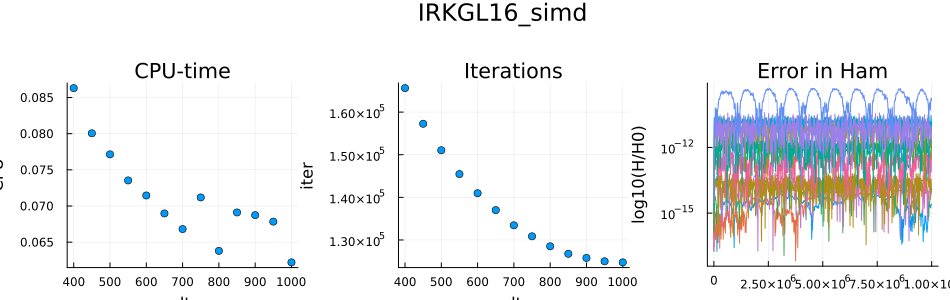

,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0

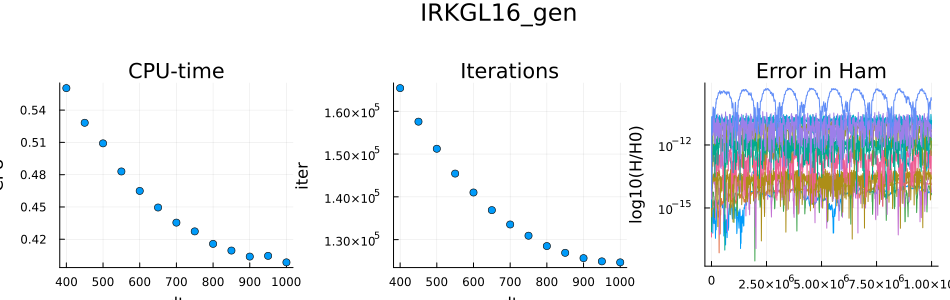

In [8]:
ddt0_irk16=collect(400.:50:1000)  
nruns=1

alg=IRKGL16(simd=true, second_order_ode=true)
sols_irk16_simd=run_many_IRKGL16(alg, prob, ddt0_irk16, HAM, nruns=nruns)
fig=plots_IRKGL16("IRKGL16_simd",prob,HAM,sols_irk16_simd)
display(fig)
#
alg=IRKGL16(simd=false, second_order_ode=true)
sols_irk16_gen=run_many_IRKGL16(alg,prob,ddt0_irk16,HAM, nruns=nruns)
fig=plots_IRKGL16("IRKGL16_gen",prob,HAM,sols_irk16_gen)
display(fig)

In [9]:
[sols_irk16_simd.dts sols_irk16_simd.retcodes sols_irk16_simd.iters sols_irk16_simd.cpus sols_irk16_simd.MaxΔHlocal]

13×5 Matrix{Float64}:
  400.0  1.0  165615.0  0.086297   5.36095e-16
  450.0  1.0  157259.0  0.0800539  9.25279e-16
  500.0  1.0  151046.0  0.0771378  3.84935e-15
  550.0  1.0  145457.0  0.0735339  1.68319e-14
  600.0  1.0  140965.0  0.0714526  6.34662e-14
  650.0  1.0  137005.0  0.0689697  2.20503e-13
  700.0  1.0  133437.0  0.0668088  6.5329e-13
  750.0  1.0  130855.0  0.0711845  1.75541e-12
  800.0  1.0  128513.0  0.0637953  4.67338e-12
  850.0  1.0  126760.0  0.0691062  1.06013e-11
  900.0  1.0  125786.0  0.0687365  2.41747e-11
  950.0  1.0  124994.0  0.0678398  5.13841e-11
 1000.0  1.0  124746.0  0.0622056  9.774e-11

In [10]:
[sols_irk16_gen.dts sols_irk16_gen.retcodes sols_irk16_gen.iters sols_irk16_gen.cpus sols_irk16_gen.MaxΔHlocal]

13×5 Matrix{Float64}:
  400.0  1.0  165410.0  0.560408  6.84469e-16
  450.0  1.0  157574.0  0.528225  1.02327e-15
  500.0  1.0  151244.0  0.509109  3.92836e-15
  550.0  1.0  145439.0  0.482998  1.65256e-14
  600.0  1.0  141017.0  0.464916  6.3422e-14
  650.0  1.0  136894.0  0.449501  2.20372e-13
  700.0  1.0  133542.0  0.43546   6.53305e-13
  750.0  1.0  130916.0  0.427324  1.75521e-12
  800.0  1.0  128497.0  0.415727  4.67355e-12
  850.0  1.0  126919.0  0.409506  1.06016e-11
  900.0  1.0  125674.0  0.403911  2.41748e-11
  950.0  1.0  124922.0  0.40458   5.13839e-11
 1000.0  1.0  124687.0  0.398537  9.774e-11

<a href="#top">Back to the top</a>

## 2nd order explicit symplectic integrations

In [11]:
flows=[flowH1Nbody!, flowH2Nbody!]
prob=SplittingProblem(flows, u0, tspan, Gm)

HAM=NbodyEnergy
@show(HAM(u0,Gm))

HAM(u0, Gm) = -9.522620605966966e-12


-9.522620605966966e-12

### Composition methods

In [12]:
#ddt0_split=collect(5.:5:80)
#ddt0_split=[8.,10., 12.,14.,16.,18.]
ddt0_split=vcat([5.,10.],[12.,14.,16.,18.],collect(20.:5:80))
nruns=1

s=1; r=2
alg=Splitting_alg(r=r, rkn=false)
sols_split_r2=run_many_Splitting(s, alg, prob, ddt0_split, HAM, nruns=nruns)
#fig=plots_Splitting("Split r=2", alg, prob, HAM, sols_split_r2)
#display(fig)
#
s=5; r=4
alg=Splitting_alg(r=r, rkn=false)
sols_split_r4=run_many_Splitting(s, alg, prob, s*ddt0_split, HAM, nruns=nruns)
#
s=13; r=6
alg=Splitting_alg(r=r, rkn=false)
sols_split_r6=run_many_Splitting(s, alg, prob, s*ddt0_split, HAM, nruns=nruns)
#
s=21; r=8
alg=Splitting_alg(r=r, rkn=false)
sols_split_r8=run_many_Splitting(s, alg, prob, s*ddt0_split, HAM, nruns=nruns)
#
s=35; r=10
alg=Splitting_alg(r=r, rkn=false)
sols_split_r10=run_many_Splitting(s, alg, prob, s*ddt0_split, HAM, nruns=nruns);


,5.0,10.0,12.0,14.0,16.0,18.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,25.0,50.0,60.0,70.0,80.0,90.0,100.0,125.0,150.0,175.0,200.0,225.0,250.0,275.0,300.0,325.0,350.0,375.0,400.0,65.0,130.0,156.0,182.0,208.0,234.0,260.0,325.0,390.0,455.0,520.0,585.0,650.0,715.0,780.0,845.0,910.0,975.0,1040.0,105.0,210.0,252.0,294.0,336.0,378.0,420.0,525.0,630.0,735.0,840.0,945.0,1050.0,1155.0,1260.0,1365.0,1470.0,1575.0,1680.0,175.0,350.0,420.0,490.0,560.0,630.0,700.0,875.0,1050.0,1225.0,1400.0,1575.0,1750.0,1925.0,2100.0,2275.0,2450.0,2625.0,2800.0

In [13]:
[sols_split_r2.MaxΔHlocal sols_split_r4.MaxΔHlocal sols_split_r6.MaxΔHlocal sols_split_r8.MaxΔHlocal sols_split_r10.MaxΔHlocal] 

19×5 Matrix{Float64}:
 5.00324e-9  3.05293e-11  1.32059e-13  8.39909e-15  6.14083e-15
 3.96174e-8  9.75562e-10  1.66974e-11  3.30465e-12  5.69914e-12
 6.80249e-8  2.42571e-9   5.91938e-11  1.70068e-11  3.94059e-11
 1.0724e-7   5.23734e-9   1.74461e-10  6.6523e-11   2.05169e-10
 1.58738e-7  1.0192e-8    4.41051e-10  2.15556e-10  8.16632e-10
 2.23978e-7  1.83247e-8   1.00016e-9   6.12561e-10  2.7275e-9
 3.0442e-7   3.09828e-8   2.06035e-9   1.53515e-9   7.82936e-9
 5.80608e-7  9.38527e-8   9.62379e-9   1.06279e-8   6.83916e-8
 9.80353e-7  2.31557e-7   3.37086e-8   4.95571e-8   3.81112e-7
 1.52802e-6  4.93694e-7   9.61021e-8   1.74991e-7   1.42812e-6
 2.239e-6    9.44982e-7   2.35499e-7   5.37483e-7   4.4163e-6
 3.13674e-6  1.6605e-6    5.13287e-7   1.37479e-6   1.09582e-5
 4.24618e-6  2.73699e-6   1.02171e-6   3.05673e-6   2.42759e-5
 5.58097e-6  4.26796e-6   1.88094e-6   6.14179e-6   4.72143e-5
 7.17215e-6  6.39109e-6   3.23716e-6   1.15661e-5   8.18751e-5
 9.02283e-6  9.262e-6     5.24

### RKN symplectic integrations

In [14]:
s=14; r=6
alg=Splitting_alg(r=r, rkn=true)
sols_split_rkn6=run_many_Splitting(s, alg, prob, s*ddt0_split, HAM, nruns=nruns)
#
s=19; r=8; rkn=true
alg=Splitting_alg(r=r, rkn=true)
sols_split_rkn8=run_many_Splitting(s, alg, prob, s*ddt0_split, HAM, nruns=nruns);

,70.0,140.0,168.0,196.0,224.0,252.0,280.0,350.0,420.0,490.0,560.0,630.0,700.0,770.0,840.0,910.0,980.0,1050.0,1120.0,95.0,190.0,228.0,266.0,304.0,342.0,380.0,475.0,570.0,665.0,760.0,855.0,950.0,1045.0,1140.0,1235.0,1330.0,1425.0,1520.0

In [15]:
[sols_split_rkn6.MaxΔHlocal sols_split_rkn8.MaxΔHlocal] 

19×2 Matrix{Float64}:
 2.48447e-14  4.26442e-15
 2.99375e-12  9.33486e-13
 1.0684e-11   4.83504e-12
 3.145e-11    1.92385e-11
 7.99096e-11  6.43403e-11
 1.79319e-10  1.85368e-10
 3.793e-10    4.76786e-10
 1.79382e-9   3.52712e-9
 6.36513e-9   1.80293e-8
 1.84822e-8   7.14573e-8
 4.6456e-8    2.28159e-7
 1.04405e-7   6.34898e-7
 2.14173e-7   1.54266e-6
 4.07678e-7   3.34195e-6
 7.3099e-7    6.62882e-6
 1.24436e-6   1.22e-5
 2.01695e-6   2.09072e-5
 3.14488e-6   3.46854e-5
 4.73911e-6   5.52088e-5

<a href="#top">Back to the top</a>

## Benchmarks diagrams

### Work-precision diagrams

In [16]:
[ddt0_irk16 sols_irk16_simd.MaxΔHlocal  sols_irk16_simd.cpus]

13×3 Matrix{Float64}:
  400.0  5.36095e-16  0.086297
  450.0  9.25279e-16  0.0800539
  500.0  3.84935e-15  0.0771378
  550.0  1.68319e-14  0.0735339
  600.0  6.34662e-14  0.0714526
  650.0  2.20503e-13  0.0689697
  700.0  6.5329e-13   0.0668088
  750.0  1.75541e-12  0.0711845
  800.0  4.67338e-12  0.0637953
  850.0  1.06013e-11  0.0691062
  900.0  2.41747e-11  0.0687365
  950.0  5.13841e-11  0.0678398
 1000.0  9.774e-11    0.0622056

In [17]:
[ddt0_split sols_split_r2.MaxΔHlocal sols_split_r2.cpus]

19×3 Matrix{Float64}:
  5.0  5.00324e-9  0.243424
 10.0  3.96174e-8  0.121667
 12.0  6.80249e-8  0.101087
 14.0  1.0724e-7   0.0878232
 16.0  1.58738e-7  0.0787028
 18.0  2.23978e-7  0.0682928
 20.0  3.0442e-7   0.0615265
 25.0  5.80608e-7  0.0495039
 30.0  9.80353e-7  0.0407309
 35.0  1.52802e-6  0.0363028
 40.0  2.239e-6    0.03093
 45.0  3.13674e-6  0.0276685
 50.0  4.24618e-6  0.0247616
 55.0  5.58097e-6  0.0223179
 60.0  7.17215e-6  0.0204594
 65.0  9.02283e-6  0.0191457
 70.0  1.11671e-5  0.0176227
 75.0  1.36153e-5  0.0164444
 80.0  1.63685e-5  0.0153569

In [18]:
sols2plot=[sols_irk16_simd, sols_irk16_gen,
           sols_split_r2, sols_split_r4, sols_split_r6, sols_split_r8, sols_split_r10,
           sols_split_rkn6, sols_split_rkn8]

labels2plot=["IRKGL16(simd)", "IRKGL16(gen)", 
              "Strang(r=2)", "SUZ90(r=4)", "SS05(r=6)", "SS05(r=8)", "SS05(r=10)", 
              "BM02(rkn6)", "BCE22(rkn8)" ]
colors2plot = [:red, :blue, :green, :orange, :purple, :cyan, :magenta, :teal, :gold];

In [19]:
index0=3   # IRKGL16: h=16, index0=3 (exact solution)
idx=9     # IRKGL16: index1=9 optimum step-size

index=[idx]
compute_index_ge_cpu!(index, sols_irk16_simd.cpus[idx], sols2plot[2:end])

for i in 1:length(index)
    
    k=index[i]
    println(k, " , ", labels2plot[i], " , ", sols2plot[i].dts[k], " , ", sols2plot[i].cpus[k])
    
end

9 , IRKGL16(simd) , 800.0 , 0.063795314
13 , IRKGL16(gen) , 1000.0 , 0.398537314
6 , Strang(r=2) , 18.0 , 0.068292799
4 , SUZ90(r=4) , 70.0 , 0.065908233
3 , SS05(r=6) , 156.0 , 0.072839075
3 , SS05(r=8) , 252.0 , 0.071370656
3 , SS05(r=10) , 420.0 , 0.070788166
3 , BM02(rkn6) , 168.0 , 0.072453617
3 , BCE22(rkn8) , 228.0 , 0.072121678


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


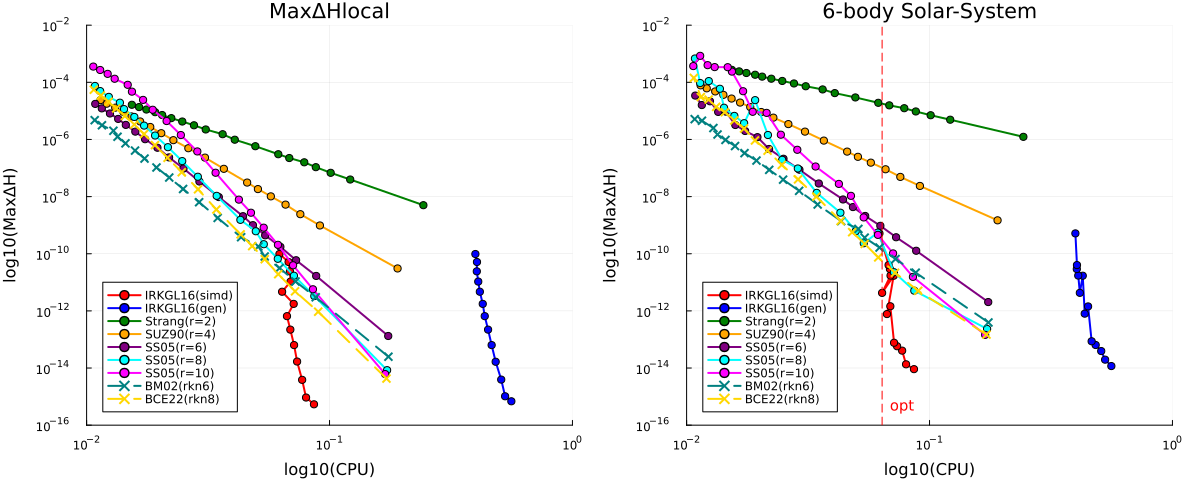

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [20]:
yrange=(1e-16, 1e-2)
xrange=(1e-2,1e0)

sols=sols_irk16_simd
pl1=plot( sols.cpus , sols.MaxΔHlocal, scale=:log10,
          markershape=:circle, lw=2,
          ylimits=yrange, xlimits=xrange,
          label=labels2plot[1], color=colors2plot[1],
          legend=:bottomleft,
          title="MaxΔHlocal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)")

for i in 2:length(sols2plot)
    
    sols=sols2plot[i]
    
    if occursin("rkn", labels2plot[i])
        
        plot!(pl1, sols.cpus , sols.MaxΔHlocal, 
        markershape=:xcross, lw=2, ls=:dash,
        label=labels2plot[i], color=colors2plot[i],
        scale=:log10)
    
    else
        plot!(pl1, sols.cpus , sols.MaxΔHlocal, 
        markershape=:circle, lw=2,
        label=labels2plot[i], color=colors2plot[i],
        scale=:log10)
    end
    
end

#########################################

sols=sols_irk16_simd
pl2=plot( sols.cpus , sols.MaxΔHglobal, scale=:log10,
         markershape=:circle, lw=2,
         ylimits=yrange, xlimits=xrange,
         label=labels2plot[1], color=colors2plot[1],
         legend=:bottomleft,
         title="6-body Solar-System", xlabel="log10(CPU)", ylabel="log10(MaxΔH)")


for i in 2:length(sols2plot)
    
    sols=sols2plot[i]
    
   if occursin("rkn", labels2plot[i])
        
        plot!(pl2, sols.cpus , sols.MaxΔHglobal, 
        markershape=:xcross, lw=2, ls=:dash,
        label=labels2plot[i], color=colors2plot[i],
        scale=:log10)
    
    else
        plot!(pl2, sols.cpus , sols.MaxΔHglobal, 
        markershape=:circle, lw=2,
        label=labels2plot[i], color=colors2plot[i],
        scale=:log10)
    end

end

vline!(pl2, [sols_irk16_simd.cpus[index[1]]], line=:dash, label="", color=:red)
annotate!((sols_irk16_simd.cpus[index[1]]+0.38, 0.05), text("opt", :red, 10, :center))

plot(pl1, pl2, layout=(1,2), size=(1200,500), 
    bottom_margin=10Plots.mm,
    left_margin=5Plots.mm, right_margin=5Plots.mm)

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


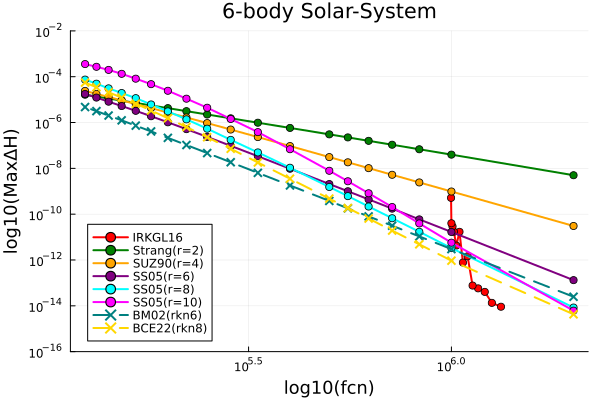

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [34]:
yrange=(1e-16, 1e-2)
fcn=8*(sols_irk16_simd.iters)


sols=sols_irk16_simd
pl3=plot( fcn , sols.MaxΔHglobal, scale=:log10,
         markershape=:circle, lw=2,
         ylimits=yrange,    
         label="IRKGL16", color=colors2plot[1],
         title="6-body Solar-System", 
         xlabel="log10(fcn)", ylabel="log10(MaxΔH)",
         legend=:bottomleft,
         guidefont=font(12), labelsize=10)


for i in 3:length(sols2plot)
       
   sols=sols2plot[i]
    
   if occursin("rkn", labels2plot[i])
       plot!(pl3, sols.nflowsH3 , sols.MaxΔHlocal, 
       markershape=:xcross, lw=2, ls=:dash,
       label=labels2plot[i], color=colors2plot[i],
       scale=:log10)
        
   else 
       plot!(pl3, sols.nflowsH3 , sols.MaxΔHlocal, 
             markershape=:circle, lw=2,
             label=labels2plot[i], color=colors2plot[i],
             scale=:log10)
   end

end

display(pl3)

In [35]:
savefig("./figures/Fig2a.pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


"/home/mikel/Nextcloud/Gure taldea (Ehu box)/6-Splitting-metodoak/Splitting Solvers Implementation/Experiments_Article/6-Body Solar System/figures/Fig2a.pdf"

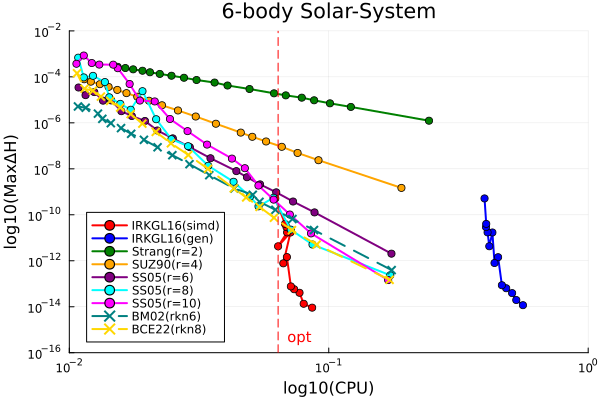

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [23]:
plot(pl2)

In [24]:
savefig("./figures/Fig2b.pdf")

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


"/home/mikel/Nextcloud/Gure taldea (Ehu box)/6-Splitting-metodoak/Splitting Solvers Implementation/Experiments_Article/6-Body Solar System/figures/Fig2b.pdf"

<a href="#top">Back to the top</a>

### Error in Energy

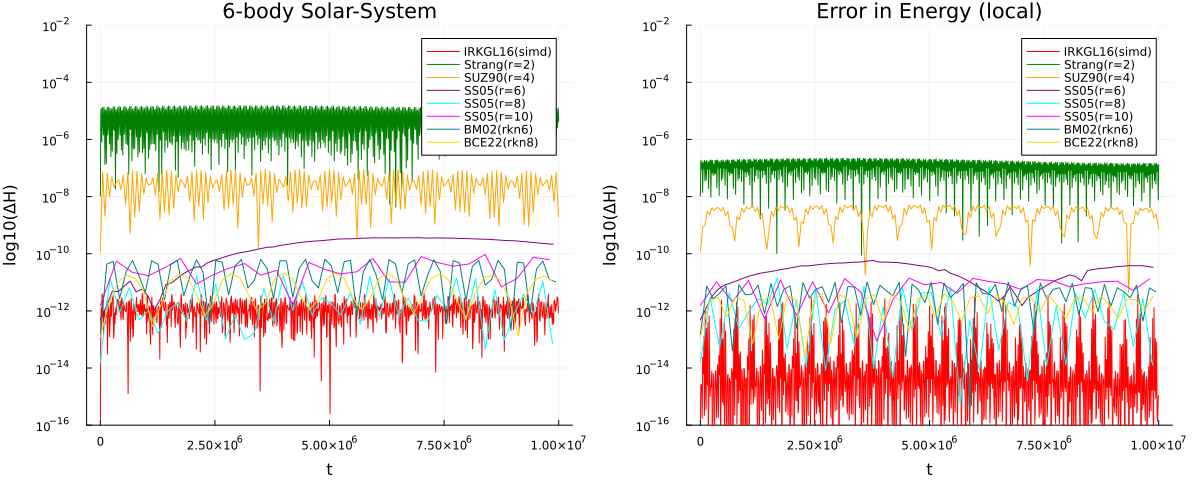

In [25]:
yrange=(1e-16, 1e-2)

onesols2plot=[sols_irk16_simd.sols[index[1]], sols_split_r2.sols[index[3]], sols_split_r4.sols[index[4]],
              sols_split_r6.sols[index[5]],   sols_split_r8.sols[index[6]], sols_split_r10.sols[index[7]],
              sols_split_rkn6.sols[index[8]], sols_split_rkn8.sols[index[9]]]


HAM=NbodyEnergy
H0=HAM(u0_B,Gm_B)


H = [HAM(BigFloat.(u),Gm_B) for u in sols_irk16_simd.sols[index[1]].u]
ΔH0 = @. Float64(abs(H/H0-1))
ΔH0loc = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))

m0 = max(1,div(Int64(ceil((tF-t0)/ddt0_irk16[index[1]])),1000))

pl3=plot(sols_irk16_simd.sols[index[1]].t[2:m0:end], abs.(ΔH0[2:m0:end]),
        ylimits=yrange,
        xlabel="t", ylabel="log10(ΔH)",title="6-body Solar-System",
        label=labels2plot[1],color=colors2plot[1],
        yscale=:log10, legend=:topright)

pl4=plot(sols_irk16_simd.sols[index[1]].t[2:m0:end], abs.(ΔH0loc[1:m0:end]),
        ylimits=yrange,
        xlabel="t", ylabel="log10(ΔH)",title="Error in Energy (local)",
        label=labels2plot[1],color=colors2plot[1],
        yscale=:log10)

# splitting

for k in 2:length(onesols2plot)
    m0 = max(1,div(Int64(ceil((tF-t0)/ddt0_split[index[k+1]])),1000))
    solk=onesols2plot[k]
    labelk=labels2plot[k+1]
    colork=colors2plot[k+1]
    
    H = [HAM(BigFloat.(u),Gm_B) for u in solk.u]
    ΔH0 = @. Float64(abs(H/H0-1))
    ΔH0loc = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
    plot!(pl3, solk.t[2:m0:end], abs.(ΔH0[2:m0:end]), yscale=:log10, label=labelk, color=colork)
    plot!(pl4, solk.t[2:m0:end], abs.(ΔH0loc[1:m0:end]), yscale=:log10, label=labelk, color=colork)
end


fig=plot(pl3, pl4, layout=(1,2), size=(1200,500), 
    bottom_margin=10Plots.mm,
    left_margin=5Plots.mm, right_margin=5Plots.mm)


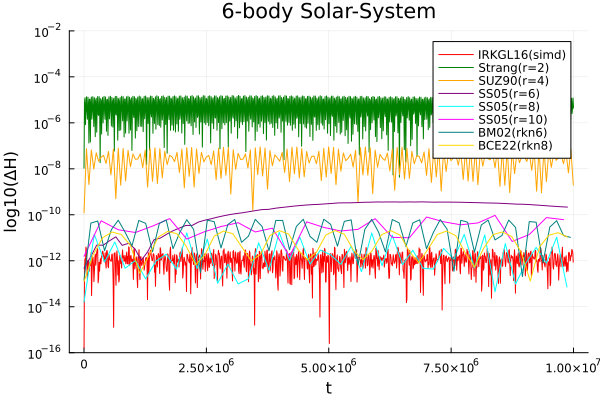

In [26]:
plot(pl3)

In [27]:
savefig("./figures/Fig2c.pdf")

"/home/mikel/Nextcloud/Gure taldea (Ehu box)/6-Splitting-metodoak/Splitting Solvers Implementation/Experiments_Article/6-Body Solar System/figures/Fig2c.pdf"

<a href="#top">Back to the top</a>

### Error in Solution

In [28]:
errors2plot=[sols_irk16_simd.sols[index[1]], sols_split_r2.sols[index[3]], sols_split_r4.sols[index[4]],
              sols_split_r6.sols[index[5]],   sols_split_r8.sols[index[6]], sols_split_r10.sols[index[7]],
              sols_split_rkn6.sols[index[8]], sols_split_rkn8.sols[index[9]]]

ddt02plot=[sols_irk16_simd.dts[index[1]], sols_split_r2.dts[index[3]], sols_split_r4.dts[index[4]],
           sols_split_r6.dts[index[5]],   sols_split_r8.dts[index[6]], sols_split_r10.dts[index[7]],
           sols_split_rkn6.dts[index[8]], sols_split_rkn8.dts[index[9]]]

labels2plot_er=["IRKGL16(simd)",  
                "Strang(r=2)", "SUZ90(r=4)", "SS05(r=6)", "SS05(r=8)", "SS05(r=10)",
                "BM02(rkn6)", "BCE22(rkn8)"] 

colors2plot_er=[:red, :green, :orange, :purple, :cyan, :magenta, :teal, :gold];


In [29]:
yrange=(1e-14, 1e3)

qerr=Array{Array{Float64,1}}(undef,N)
ploterr = Vector{Plots.Plot}(undef, length(errors2plot))

for k in 1:length(errors2plot)

        
    w=lcm_floats_vector(vcat(ddt0_irk16[index0],ddt02plot[k]))
    ii=Int64.(w./(vcat(ddt0_irk16[index0],ddt02plot[k]))).+1
    
    v0=sols_irk16_simd.sols[index0].t[ii[1]:ii[1]-1:3*ii[1]] 
    v1=errors2plot[k].t[ii[2]:ii[2]-1:3*ii[2]]
    
    println("k=", k, ",",labels2plot[k],",", v0 )
    println("k=", k, ",",labels2plot[k],",", v1 )
    println("*****************************")
    
    
    ploterr[k]=plot(title=string("6-BSS ",labels2plot_er[k]),
             ylims=yrange,
             yscale=:log10,
             xlabel="t (years)",
             ylabel="error in position", label="")
    
    for i in 1:N
        qerr[i]=map((u0,u1)-> (norm(BigFloat.(u0[:,i,1])-BigFloat.(u1[:,i,1]))/norm(BigFloat.(u0[:,i,1]))), 
                     sols_irk16_simd.sols[index0].u[ii[1]:ii[1]-1:end], errors2plot[k].u[ii[2]:ii[2]-1:end])
    end
      
    
    #tt=sols_irk16_simd.sols[index0].t[ii[1]:ii[1]-1:end]
    tt=errors2plot[k].t[ii[2]:ii[2]-1:end]
    plot!(ploterr[k], tt , qerr, label="")

    
end

#fig=plot(pl3, pe1, layout=(1,2), size=(1200,500), 
#    bottom_margin=10Plots.mm,
#    left_margin=5Plots.mm, right_margin=5Plots.mm)

k=1,IRKGL16(simd),[4000.0, 8000.0, 12000.0]
k=1,IRKGL16(simd),[4000.0, 8000.0, 12000.0]
*****************************
k=2,IRKGL16(gen),[4500.0, 9000.0, 13500.0]
k=2,IRKGL16(gen),[4500.0, 9000.0, 13500.0]
*****************************
k=3,Strang(r=2),[3500.0, 7000.0, 10500.0]
k=3,Strang(r=2),[3500.0, 7000.0, 10500.0]
*****************************
k=4,SUZ90(r=4),[19500.0, 39000.0, 58500.0]
k=4,SUZ90(r=4),[19500.0, 39000.0, 58500.0]
*****************************
k=5,SS05(r=6),[31500.0, 63000.0, 94500.0]
k=5,SS05(r=6),[31500.0, 63000.0, 94500.0]
*****************************
k=6,SS05(r=8),[10500.0, 21000.0, 31500.0]
k=6,SS05(r=8),[10500.0, 21000.0, 31500.0]
*****************************
k=7,SS05(r=10),[21000.0, 42000.0, 63000.0]
k=7,SS05(r=10),[21000.0, 42000.0, 63000.0]
*****************************
k=8,BM02(rkn6),[28500.0, 57000.0, 85500.0]
k=8,BM02(rkn6),[28500.0, 57000.0, 85500.0]
*****************************


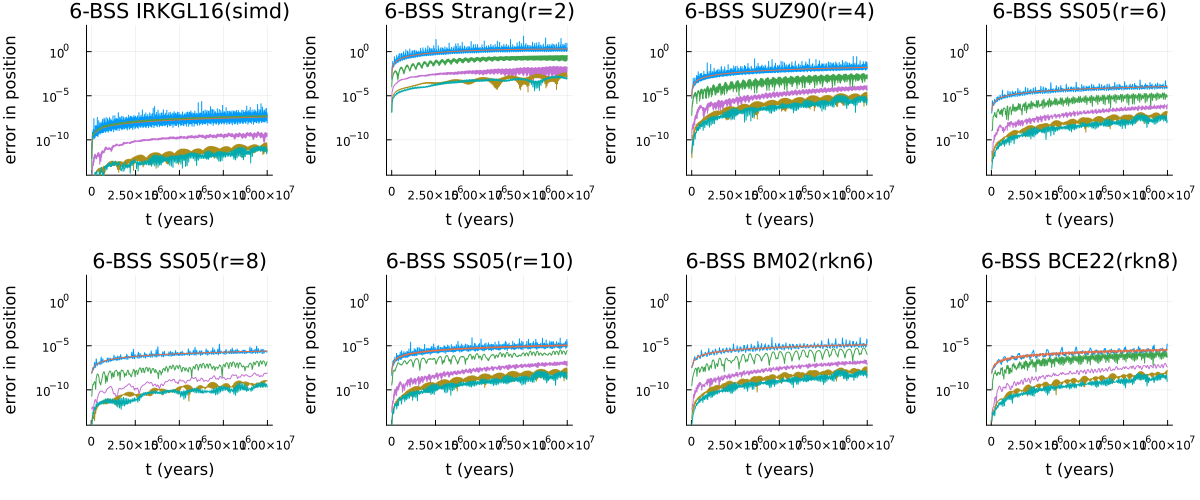

In [30]:
fig=plot(ploterr[1],ploterr[2], ploterr[3], ploterr[4],
         ploterr[5],ploterr[6], ploterr[7], ploterr[8],
        layout=(2,4), size=(1200,500), 
    bottom_margin=10Plots.mm,
    left_margin=5Plots.mm, right_margin=5Plots.mm)

In [31]:
yrange=(1e-14, 1e0)

for k in 1:length(ploterr)

     plot(ploterr[k],
         ylims=yrange,
         yscale=:log10,
         xlabel="t (years)",
         ylabel="error in position", label="")
       #  label=planets,legend=:topleft)
    
    savefig(string("./figures/Fig2d-", k, ".pdf"))
    
end